In [1]:
import numpy as np   # Importo paquete de álgebra lineal
import matplotlib.pyplot as plt   # Importo paquete de gráficos
import copy
import mef
plt.rc('figure', figsize=(15,8))   # Para gráficos
plt.rc('font',size=22)             # Para gráficos
import gmsh

In [2]:
# Abro gmsh.
gmsh.initialize()

In [3]:
# Armo el modelo.
gmsh.model.add('Chapa_fisurada')

## Punto 2

Determine la **deformación** y los **esfuerzos principales** en función de la posición para una chapa con un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las dimensiones de la chapa son de $20\: x\: 10\: in$ y su espesor de $1\ in$. El radio del agujero central es también de $1\: in$. Tome $E = 30 x 10^{6}\: psi$ y $\nu = 0,30$.

Analice el problema con número creciente de elementos y estudie su convergencia.

<center><img src="ImgProb02.png"></center>

In [4]:
# Defino los grados de libertad por nodo "glxn".
glxn = 2

In [5]:
# Defino el módulo de elasticidad "E" de la viga.
E = 30e6   # psi=lb/in^2

# Defino módulo de Poisson "nu".
nu = 0.3

# Defino la longitud "L" .
L = 20   # in

# Defino la altura "h" .
h = 10   # in

# Defino espesor "t"
t = 1   # in

# Defino radio "r" del agujero central.
r = 1   # in

# Defino el valor de la carga distribuida "T".
T = 1000   # psi=lb/in^2

In [6]:
# Matriz "D" que relaciona tensores tensión-deformación, para problema de tensiones planas.
D = (E/(1-(nu**2)))*np.array([[1,nu,0],
                              [nu,1,0],
                              [0,0,0.5*(1-nu)]])

Por simetría, se trabajará con el cuadrante superior derecho de la chapa.

In [7]:
# Defino variable "lc" para la densidad de triángulos en las inmediaciones de cada punto.
lc = 0.3

In [8]:
# Defino las coordenadas de los puntos.
pc = gmsh.model.geo.addPoint(0,0,0,lc)
p1 = gmsh.model.geo.addPoint(r,0,0,lc/15) #lc/20)
p2 = gmsh.model.geo.addPoint(L/2,0,0,lc) #lc/2)
p3 = gmsh.model.geo.addPoint(L/2,h/2,0,lc) #lc/2)
p4 = gmsh.model.geo.addPoint(0,h/2,0,lc) #lc/2)
p5 = gmsh.model.geo.addPoint(0,r,0,lc/15) # lc/20

In [9]:
# Defino las líneas.
l1 = gmsh.model.geo.addLine(p1,p2)
l2 = gmsh.model.geo.addLine(p2,p3)
l3 = gmsh.model.geo.addLine(p3,p4)
l4 = gmsh.model.geo.addLine(p4,p5)
c1 = gmsh.model.geo.addCircleArc(p5,pc,p1)

In [10]:
# Defino los bordes del modelo.
C1 = gmsh.model.geo.addCurveLoop([l1,l2,l3,l4,c1])

In [11]:
# Defino la superficie.
S1 = gmsh.model.geo.addPlaneSurface([C1])

In [12]:
# Aviso que ya están todos los elementos geométricos.
gmsh.model.geo.synchronize()

In [13]:
# Por simetría del sistema, la línea de abajo no se puede mover porque la chapa no está traccionada verticalmente.
Empotrado_hori = gmsh.model.addPhysicalGroup(1, [l1])
gmsh.model.setPhysicalName(1,Empotrado_hori,'Empotrado horizontal')

# Por simetría del sistema, la línea izquierda no se puede mover porque la chapa está traccionada horizontalmente tanto
# para la derecha como para la izquierda en igual magnitud.
Empotrado_vert = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,Empotrado_vert,'Empotrado vertical')

In [14]:
# Defino el borde traccionado.
Traccionado = gmsh.model.addPhysicalGroup(1,[l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

In [15]:
Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie,'Superficie')

In [16]:
# Genero el mallado. De dimensión "2".
gmsh.model.mesh.generate(2)

In [17]:
# Actualizo.
gmsh.model.geo.synchronize()

In [18]:
# Corro gmsh para que me tire una ventana con el mallado.
gmsh.fltk.run()

Obtengo información sobre los nodos.

In [19]:
NodeInfo = gmsh.model.mesh.get_nodes()
Nn = NodeInfo[0].shape[0]        # Número de nodos "Nn".
MN = NodeInfo[1].reshape(Nn,3)   # Matriz de nodos "MN".

In [20]:
## PROBLEMA: Me considera el punto en (0,0,0) como nodo, lo cual es incorrecto porque no pertenece a la superficie.
## SOLUCIÓN CORRECTA: Definir bien los grupos físicos para que no pase. ¡¡¡HACERLA EN PRÓXIMA MEJORA!!!

## SOLUCIÓN QUE HICE: Pasé (0,0,0) al final del todo, porque esto facilitará considerarlo en el vector "s" y de esta 
# manera poder asignarle "Us" nulos.
aux = MN[0,:]
MN = np.append(MN[1:,:],[aux],0)

Obtengo información sobre los elementos.

In [21]:
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)   # Obtengo elementos de tipo "2" (triángulos).
Ne = ETAGS.shape[0]              # Número de elementos "Ne".
Nnxe = 3                         # Número de nodos por elemento "Nnxe".
MC = ELEMENTS.reshape(Ne,Nnxe)   # Matriz de conectividad "MC".
MC = MC - np.ones([Ne,Nnxe])     # Resto 1 para acomodar a lenguaje PYTHON.
MC = MC.astype(int)

In [22]:
# Defino vector "A" que almacena área de cada elemento.
A = np.zeros(Ne)

# Defino "alpha", "beta" y "gamma" para cada elemento.
alpha = np.zeros([3,Ne])
beta = np.zeros([3,Ne])
gamma = np.zeros([3,Ne])

# Defino diccionario en el que se almacenará, para cada elemento, la matriz "B" que relaciona deformación-desplazamiento.
B = {}

# Defino diccionario en el que se almacenará, para cada elemento, la matriz elemental "Ke".
Ke = {}

# Calculo las áreas orientadas, GENERALIZADO, usando producto vectorial.
for e in range(Ne):
    nodos = MC[e,:] # Guarda los nodos del elemento "e".
    alpha[0,e] = MN[nodos[1],0]*MN[nodos[2],1] - MN[nodos[2],0]*MN[nodos[1],1]
    alpha[1,e] = MN[nodos[0],0]*MN[nodos[2],1] - MN[nodos[2],0]*MN[nodos[0],1]
    alpha[2,e] = MN[nodos[0],0]*MN[nodos[1],1] - MN[nodos[1],0]*MN[nodos[0],1]
    beta[0,e] = MN[nodos[1],1]-MN[nodos[2],1]  # "1" es Y
    beta[1,e] = MN[nodos[2],1]-MN[nodos[0],1]
    beta[2,e] = MN[nodos[0],1]-MN[nodos[1],1]
    gamma[0,e] = MN[nodos[2],0]-MN[nodos[1],0]  # "0" es X
    gamma[1,e] = MN[nodos[0],0]-MN[nodos[2],0]
    gamma[2,e] = MN[nodos[1],0]-MN[nodos[0],0]
    A[e] = (alpha[0,e] - alpha[1,e] + alpha[2,e])/2
    B[e] = (1/(2*A[e]))*np.array([[beta[0,e],0,beta[1,e],0,beta[2,e],0],
                            [0,gamma[0,e],0,gamma[1,e],0,gamma[2,e]],
                            [gamma[0,e],beta[0,e],gamma[1,e],beta[1,e],gamma[2,e],beta[2,e]]])
    Ke[e] = t*np.abs(A[e])*np.transpose(B[e]).dot(D.dot(B[e]))

In [23]:
# Defino matriz global "Kg".
Kg = np.zeros([glxn*Nn, glxn*Nn])

# Ensamblo las matrices elementales "Ke" para obtener la matriz global "Kg".
for e in range(Ne): 
    for i in range(Nnxe):
        rangoi = np.linspace(i*glxn, (i+1)*glxn-1, Nnxe).astype(int)
        rangoni = np.linspace(MC[e, i]*glxn, (MC[e, i]+1)*glxn-1, Nnxe).astype(int)
        for j in range(Nnxe):
            rangoj = np.linspace(j*glxn, (j+1)*glxn-1, Nnxe).astype(int)
            rangonj = np.linspace(MC[e, j]*glxn, (MC[e, j]+1)*glxn-1, Nnxe).astype(int)
            Kg[np.ix_(rangoni, rangonj)] += Ke[e][np.ix_(rangoi, rangoj)]

Obtengo los nodos empotrados horizontalmente. **NO ESTÁN EN NOTACIÓN PYTHON**, debo restar 1.

In [24]:
nodos_empot_hori, xyz_empot_hori = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_hori)

Obtengo los nodos empotrados verticalmente. **NO ESTÁN EN NOTACIÓN PYTHON**, debo restar 1.

In [25]:
nodos_empot_vert, xyz_empot_vert = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_vert)

In [26]:
# Obtengo vector "s" que contiene los nodos con condiciones de vínculo en desplazamiento.
# - Para los nodos en la línea horizontal empotrada, será restricción en el eje Y.
# - Para los nodos en la línea vertical empotrada, será restricción en el eje X.
s = []

for n in nodos_empot_vert-1:   # El -1 va porque no están en numeración PYTHON.
    s.append(glxn*n)
for n in nodos_empot_hori-1:   # El -1 va porque no están en numeración PYTHON.
    s.append(glxn*n + 1)

# ESTO lo hago por tener el punto (0,0,0) al final del todo, así puedo empotrarlo y resolver el ejercicio. CUANDO CORRIJA
# EL PROGRAMA, debería borrar estas dos líneas.
s.append((NodeInfo[0][0]-1)*glxn)
s.append((NodeInfo[0][0]-1)*glxn + 1)

s = np.array(s).astype(int)

# Obtengo vector "Us" con los valores de las condiciones de vínculo.
Us = np.zeros([s.shape[0]]).reshape([-1,1])

# Defino vector "r" que contiene los nodos con condiciones de vínculo en fuerza. Es el complemento de "s".
r = np.array([i for i in range(Nn*glxn) if i not in s])

Obtengo los nodos traccionados. **NO ESTÁN EN NOTACIÓN PYTHON**, debo restar 1.

In [27]:
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)

# Obtengo elementos tipo línea desde aquellos nodos, es decir, líneas conectoras entre nodos en el extremo traccionado.
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])

Nlineastraccionadas = len(Ttraccionada[0])   # Número de líneas.

# Expreso cada par de nodos correspondientes a una línea traccionada, en la matriz "MCtraccionadas".
MCtraccionadas = Ltraccionada[0].reshape(Nlineastraccionadas,2) - 1   # El -1 es para pasar los nodos a notación PYTHON.

In [28]:
# Defino vector "Fr" con los valores de las condiciones de vínculo.
Fr = np.zeros_like(r)
for e in range(Nlineastraccionadas):
    nodo1 = MCtraccionadas[e,0].astype(int)   # Primer nodo en la línea
    nodo2 = MCtraccionadas[e,1].astype(int)   # Segundo nodo en la línea
    Ltraccionado = abs(MN[nodo2,1]-MN[nodo1,1])   # Calculo la distancia entre nodos adyacentes.
    # Fr[2*nodo1] += T*t*Ltraccionado/2
    # Fr[2*nodo2] += T*t*Ltraccionado/2
    # No me andan los de arriba porque no se me correlacionan las posiciones de "r" y "Fr".
    Fr[np.where(r == nodo1*2)[0][0]] += T*t*Ltraccionado/2
    Fr[np.where(r == nodo2*2)[0][0]] += T*t*Ltraccionado/2
Fr = Fr.reshape([-1,1])

In [29]:
# Llamo al paquete "mef", que contiene la función "solve" que calcula los vectores de fuerzas y torques "F", y de 
# desplazamientos y rotaciones "U", empleando MEF. 
F, U = mef.solve(Kg, r, Fr, s, Us)

In [30]:
print('Las FUERZAS (en lb) son:')
print(F)
print('Los DESPLAZAMIENTOS (en in) son:')
print(U)

Las FUERZAS (en lb) son:
[[  0.        ]
 [ 11.19588411]
 [147.        ]
 ...
 [  0.        ]
 [  0.        ]
 [  0.        ]]
Los DESPLAZAMIENTOS (en in) son:
[[ 1.04795046e-04]
 [ 0.00000000e+00]
 [ 3.51517625e-04]
 ...
 [-1.31911430e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


In [31]:
# Cálculo de tensiones.
desp_xy = U.reshape(Nn,2)
desp_xyz = np.hstack([desp_xy,np.zeros([Nn,1])])

In [32]:
# Calculo las posiciones finales de los nodos, matriz "MN_final".
MN_final = MN + desp_xyz

In [33]:
# Almacena desplazamientos de cada elemento.
desp_elem = {}
tensión = {}
for e in range(Ne):
    desp_elem[e] = desp_xyz[MC[e],:2].ravel().reshape(-1,1)   # "2" así no me toma Z
    tensión[e] = D.dot(B[e].dot(desp_elem[e])) 

In [34]:
print('La TENSIÓN (en psi) en cada elemento es:')

La TENSIÓN (en psi) en cada elemento es:


In [35]:
tensión

{0: array([[ 770.31220929],
        [-227.42356073],
        [-323.96436632]]),
 1: array([[1667.26658942],
        [ 275.74739667],
        [-478.07333865]]),
 2: array([[1265.25313812],
        [  85.85809529],
        [  94.25708644]]),
 3: array([[ 120.29274611],
        [-174.46800705],
        [ -33.51850874]]),
 4: array([[1031.11387823],
        [ -71.78322985],
        [ -88.57641015]]),
 5: array([[ 104.84747031],
        [-407.96786455],
        [-146.94631104]]),
 6: array([[1028.48791856],
        [ -26.24556018],
        [-344.77230322]]),
 7: array([[1026.74837565],
        [ -83.03818384],
        [ -86.09543785]]),
 8: array([[1333.46287299],
        [-113.73756262],
        [ -73.47836325]]),
 9: array([[ 191.26042975],
        [-111.11822514],
        [ -38.88833093]]),
 10: array([[2500.98530146],
        [ 256.90440709],
        [ -36.8533251 ]]),
 11: array([[121.07749216],
        [-24.32791209],
        [-83.80343536]]),
 12: array([[978.2128351 ],
        [ 14.

## Gráfico del ANTES y DESPUÉS de la chapa

No se nota la diferencia porque debería definir "MN_final" sumando "1e4*desp_xyz" en vez de sólo "desp_xyz", así se nota más la diferencia entre antes y después.

Text(0.5, 0, 'y (in)')

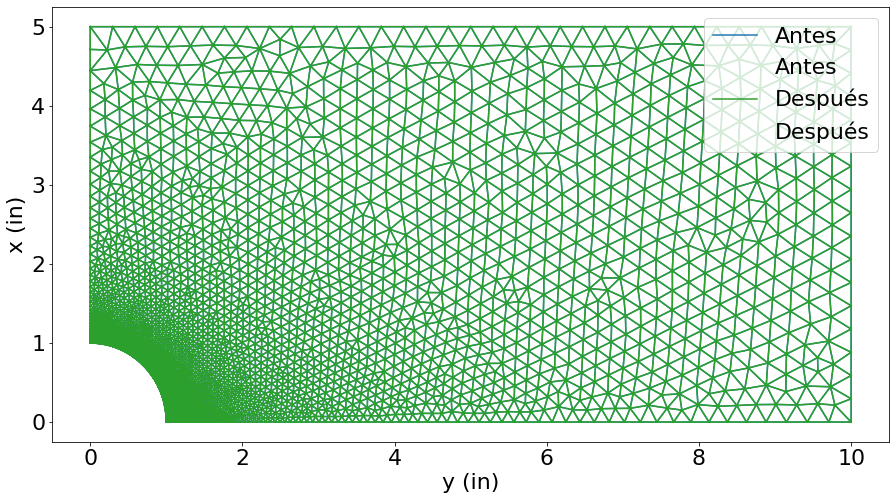

In [36]:
fig, ax = plt.subplots(figsize=(15,8))
plt.triplot(MN[:,0], MN[:,1], MC, label='Antes')
plt.triplot(MN_final[:,0], MN_final[:,1], MC, label='Después')
plt.legend()
plt.ylabel('x (in)')
plt.xlabel('y (in)')

## Gráfico de FUERZAS en los nodos

Text(0, 0.5, 'y (in)')

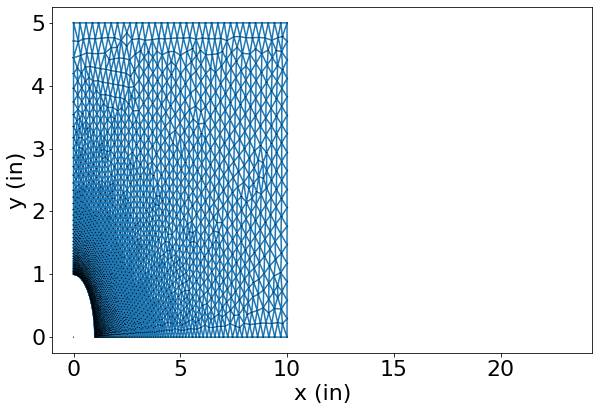

In [37]:
# Separo componentes de fuerza en X y en Y.
Fx = F[2*np.arange(Nn)]
Fy = F[2*np.arange(Nn)+1]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
ax.triplot(MN[:,0],MN[:,1],MC-MC.min(), )
ax.quiver( MN[:,0], MN[:,1], Fx, Fy, linewidth=5, units='width', scale=1e5)   # Flechas
ax.set_xlim(-1, 1.2*L+(Fx/1e3).max())
ax.set_xlabel('x (in)')
ax.set_ylabel('y (in)')

## Gráfico de DESPLAZAMIENTOS en los nodos

Text(0, 0.5, 'y (in)')

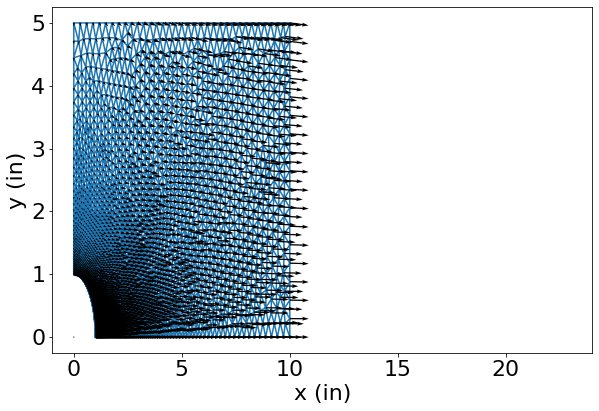

In [38]:
# Separo componentes de desplazamiento en X y en Y.
Ux = U[2*np.arange(Nn)]
Uy = U[2*np.arange(Nn)+1]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
ax.triplot(MN[:,0],MN[:,1],MC-MC.min(), )
ax.quiver( MN[:,0], MN[:,1], Ux*1e7, Uy*1e7, linewidth=5, units='width', scale=1e5)   # Flechas
ax.set_xlim(-1, 1.2*L+(Ux/1e3).max())
ax.set_xlabel('x (in)')
ax.set_ylabel('y (in)')

## Que se vea en el gmsh

### Desplazamientos

In [39]:
# Inicio una visualización.
desps = gmsh.view.add("Desplazamientos")

In [40]:
# Guardo datos en la visualización.
# Debo poner "NodeInfo[0]+1", porque sino grafica mal.
Desps = gmsh.view.addModelData(desps, 0, 'Chapa_fisurada', 'NodeData', NodeInfo[0]+1, desp_xyz, numComponents=3)

In [41]:
gmsh.option.setNumber(f'View[{desps}].VectorType',5)

### Fuerzas

In [42]:
# Guardo las fuerzas externas.
Fxyz = np.hstack((Fx,Fy, np.zeros((Nn,1))))

In [43]:
# Inicio una visualización.
fx = gmsh.view.add("Fuerzas")

In [44]:
# Guardo datos en la visualización.
# Debo poner "NodeInfo[0]+1", porque sino grafica mal.
Fz = gmsh.view.addModelData(fx, 0, 'Chapa_fisurada','NodeData',NodeInfo[0]+1, Fxyz, numComponents=3)

In [45]:
gmsh.option.setNumber(f'View[{fx}].VectorType',4)

In [46]:
gmsh.option.setNumber(f'View[{fx}].GlyphLocation',2)

### Tensiones

In [47]:
# Saco las tensiones del diccionario "tensión" y las traslado a matriz "tensiones_123", que almacena:
# - Fila "0": Tensiones en X.
# - Fila "1": Tensiones en Y.
# - Fila "2": Tensiones en XY.
tensiones_123= np.hstack(list(tensión.values()))

In [48]:
# Inicio una visualización para tensiones en X.
sigX = gmsh.view.add("Tensiones en X")

# Inicio una visualización para tensiones en Y.
# sigY = gmsh.view.add("Tensiones en Y")

# Inicio una visualización para tensiones en Y.
# sigXY = gmsh.view.add("Tensiones en XY")

In [49]:
TensionesX = gmsh.view.addModelData(sigX, 0, 'Chapa_fisurada', 'ElementData', ETAGS, tensiones_123[0,:].reshape([-1,1]) , numComponents=1 )
# TensionesY = gmsh.view.addModelData(sigY, 0, 'Chapa_fisurada', 'ElementData', ETAGS, tensiones_123[1,:].reshape([-1,1]) , numComponents=1 )
# TensionesXY = gmsh.view.addModelData(sigXY, 0, 'Chapa_fisurada', 'ElementData', ETAGS, tensiones_123[2,:].reshape([-1,1]) , numComponents=1 )

In [50]:
# Actualizo.
gmsh.model.geo.synchronize()

In [51]:
# Corro gmsh para que me tire una ventana con el mallado.
gmsh.fltk.run()

¿CÓMO BORRAR MALLADO? En el gmsh, ir a Tools, luego a Options, ahí a Mesh, y **DESTILDAR** 2D element edges.